原文代码作者：https://github.com/wzyonggege/statistical-learning-method

中文注释制作：机器学习初学者(微信公众号：ID:ai-start-com)

配置环境：python 3.6

代码全部测试通过。
![gongzhong](../gongzhong.jpg)

# 第5章 决策树

- ID3（基于信息增益）
- C4.5（基于信息增益比）
- CART（gini指数）

#### entropy：$H(x) = -\sum_{i=1}^{n}p_i\log{p_i}$

#### conditional entropy: $H(X|Y)=\sum{P(X|Y)}\log{P(X|Y)}$

#### information gain : $g(D, A)=H(D)-H(D|A)$

#### information gain ratio: $g_R(D, A) = \frac{g(D,A)}{H(A)}$

#### gini index:$Gini(D)=\sum_{k=1}^{K}p_k\log{p_k}=1-\sum_{k=1}^{K}p_k^2$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
import math
from math import log

import pprint

### 书上题目5.1

In [2]:
def create_data():
    datasets = [['sun','hot','high','weak','no'],
                ['sun','hot','high','strong','no'],
                ['cloud','hot','high','weak','yes'],
                ['sun','mild','high','weak','yes'],
                ['rain','cool','norm','weak','yes'],
                ['rain','cool','norm','strong','no'],
                ['cloud','cool','norm','strong','yes'],
                ['sun','mild','high','weak','no'],
                ['sun','cool','norm','weak','yes'],
                ['rain','mild','norm','weak','yes'],
                ['sun','mild','norm','strong','yes'],
                ['cloud','mild','high','strong','yes'],
                ['cloud','hot','norm','weak','yes'],
                ['rain','mild','high','strong','no'],
               ]
    labels = ['outlook','temp','humid','wind','tennis']
    # 返回数据集和每个维度的名称
    return datasets, labels
datasets, labels = create_data()

In [3]:
datasets, labels = create_data()

In [4]:
train_data = pd.DataFrame(datasets, columns=labels)

In [5]:
train_data

,outlook,temp,humid,wind,tennis
0,sun,hot,high,weak,no
1,sun,hot,high,strong,no
2,cloud,hot,high,weak,yes
3,sun,mild,high,weak,yes
4,rain,cool,norm,weak,yes
5,rain,cool,norm,strong,no
6,cloud,cool,norm,strong,yes
7,sun,mild,high,weak,no
8,sun,cool,norm,weak,yes
9,rain,mild,norm,weak,yes


In [6]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
    return ent

# 经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p)/data_length)*calc_ent(p) for p in feature_sets.values()])
    return cond_ent

# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent

def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [7]:
info_gain_train(np.array(datasets))

特征(outlook) - info_gain - 0.226
特征(temp) - info_gain - 0.029
特征(humid) - info_gain - 0.152
特征(wind) - info_gain - 0.048


'特征(outlook)的信息增益最大，选择为根节点特征'

---

利用ID3算法生成决策树，例5.3

In [8]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
    
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p)/data_length)*self.calc_ent(p) for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :-1], train_data.iloc[:, -1], train_data.columns[:-1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True,
                        label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [9]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [10]:
tree

{'label:': None, 'feature': 0, 'tree': {'sun': {'label:': None, 'feature': 0, 'tree': {'mild': {'label:': None, 'feature': 0, 'tree': {'high': {'label:': 'no', 'feature': None, 'tree': {}}, 'norm': {'label:': 'yes', 'feature': None, 'tree': {}}}}, 'hot': {'label:': 'no', 'feature': None, 'tree': {}}, 'cool': {'label:': 'yes', 'feature': None, 'tree': {}}}}, 'rain': {'label:': None, 'feature': 2, 'tree': {'weak': {'label:': 'yes', 'feature': None, 'tree': {}}, 'strong': {'label:': 'no', 'feature': None, 'tree': {}}}}, 'cloud': {'label:': 'yes', 'feature': None, 'tree': {}}}}

In [11]:
dt.predict(['老年', '否', '否', '一般'])

KeyError: '老年'

---

## sklearn.tree.DecisionTreeClassifier

### criterion : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

In [12]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:,:2], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [36]:
def create_data():
    datasets = [['sun','hot','high','weak','no'],
                ['sun','hot','high','strong','no'],
                ['cloud','hot','high','weak','yes'],
                ['sun','mild','high','weak','yes'],
                ['rain','cool','norm','weak','yes'],
                ['rain','cool','norm','strong','no'],
                ['cloud','cool','norm','strong','yes'],
                ['sun','mild','high','weak','no'],
                ['sun','cool','norm','weak','yes'],
                ['rain','mild','norm','weak','yes'],
                ['sun','mild','norm','strong','yes'],
                ['cloud','mild','high','strong','yes'],
                ['cloud','hot','norm','weak','yes'],
                ['rain','mild','high','strong','no'],
               ]
    labels = ['outlook','temp','humid','wind','tennis']
    # 返回数据集和每个维度的名称
    return datasets, labels
datasets, labels = create_data()

In [43]:
datasets, labels

([['sun', 'hot', 'high', 'weak', 'no'],
  ['sun', 'hot', 'high', 'strong', 'no'],
  ['cloud', 'hot', 'high', 'weak', 'yes'],
  ['sun', 'mild', 'high', 'weak', 'yes'],
  ['rain', 'cool', 'norm', 'weak', 'yes'],
  ['rain', 'cool', 'norm', 'strong', 'no'],
  ['cloud', 'cool', 'norm', 'strong', 'yes'],
  ['sun', 'mild', 'high', 'weak', 'no'],
  ['sun', 'cool', 'norm', 'weak', 'yes'],
  ['rain', 'mild', 'norm', 'weak', 'yes'],
  ['sun', 'mild', 'norm', 'strong', 'yes'],
  ['cloud', 'mild', 'high', 'strong', 'yes'],
  ['cloud', 'hot', 'norm', 'weak', 'yes'],
  ['rain', 'mild', 'high', 'strong', 'no']],
 ['outlook', 'temp', 'humid', 'wind', 'tennis'])

In [44]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
import graphviz

In [45]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(datasets, labels,)
#clf.fit(X_train, y_train,)

ValueError: could not convert string to float: 'sun'

In [40]:
clf.score(X_test, y_test)

1.0

In [41]:
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

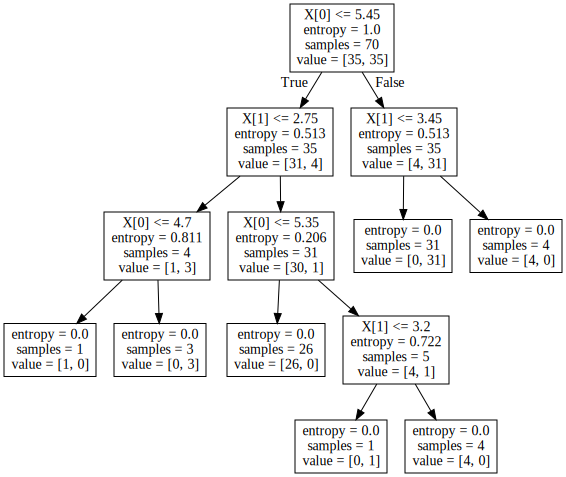

In [42]:
graphviz.Source(dot_graph)

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='The Test Table')

# 添加圆点A,A的标签是Dot A
dot.node('A', 'Dot A')

# 添加圆点 B, B的标签是Dot B
dot.node('B', 'Dot B')
# dot.view()

# 添加圆点 C, C的标签是Dot C
dot.node('C', 'Dot C')
# dot.view()

# 创建一堆边，即连接AB的两条边，连接AC的一条边。
dot.edges(['AB', 'AC', 'AB'])
# dot.view()

# 在创建两圆点之间创建一条边
dot.edge('B', 'C', 'test')
# dot.view()


# 获取DOT source源码的字符串形式
print(dot.source) 
# // The Test Table
# digraph {
#   A [label="Dot A"]
#   B [label="Dot B"]
#   C [label="Dot C"]
#   A -> B
#   A -> C
#   A -> B
#   B -> C [label=test]
# }


# 保存source到文件，并提供Graphviz引擎
dot.render('test-output/test-table.gv', view=True)
